# MIE-CGAN on image data

Here we show an example implementation of the MIE selection criterion for image data (with one channel). The code is an expansion of Yangyangii's [implementation](https://github.com/Yangyangii/GAN-Tutorial)of a basic CGAN for the MNIST dataset.

First, we install all needed packages:


In [0]:
%%capture 

!pip install torch torchvision
!pip install esda
!pip install pysal
!pip install urbanaccess 
!pip install pandana

In [0]:
import os

In [0]:
%%capture

!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree
!ldconfig
os.chdir("..")

In [0]:
import pandas as pd
import numpy as np
import datetime
import esda
import pysal
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [0]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

## Codebase

Let's first define the model and needed utility functions.

In [0]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [0]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [0]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x, c):        
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        return y_

In [0]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, condition_size=10, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [0]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

## Model training

We can now train the model. First, we access the MNIST dataset.

In [0]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Let's prepare the training settings

In [0]:
batch_size = 64
condition_size = 10

In [0]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [0]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
max_epoch = 100 
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100
check_interval = 300

In [0]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [0]:
if not os.path.exists('samples'):
    os.makedirs('samples')

And we are ready to train the model!

In [186]:
intervals = []
mies = []
mies_batch = []
rmses = []
rmses_batch = []
disc_loss = []
gen_loss = []
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1)
        y = to_onehot(y).to(DEVICE)
        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_trained = G(z, y)
        z_outputs = D(z_trained, y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % check_interval ==0:
          #calculate metrics
          for i in range(batch_size):
            #Calculate Moran's I values of input and generated data
            mi_true = pysal.explore.esda.moran.Moran_Local(x[i][0].cpu(),w,permutations=1).Is.reshape(28,28)
            mi_gen = pysal.explore.esda.moran.Moran_Local(z_trained[i][0].cpu().detach().numpy(),w,permutations=1).Is.reshape(28,28)
            #Calculate selection metrics: MIE and RMSE
            mie = np.mean(abs(np.concatenate(mi_true)-np.concatenate(mi_gen)))
            rmse = np.sqrt(np.mean((np.concatenate(np.array(x[i][0].cpu())) - np.concatenate(np.array(z_trained[i][0].cpu().detach().numpy())))**2))
            mies.append(mie)
            rmses.append(rmse)
          #Save metrics
          mies_batch.append(np.mean(mies))
          rmses_batch.append(np.mean(rmses))
          disc_loss.append(D_loss.item())
          gen_loss.append(G_loss.item())
          intervals.append(step)
          #Save models
          torch.save(G, "gen_iter %d.pkl.gz" % step)
          torch.save(D, "disc_iter %d.pkl.gz" % step)

        if step % 500 == 0:
          print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LeakyReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3

Epoch: 0/100, Step: 0, D Loss: 1.3513851165771484, G Loss: 0.6904493570327759
Epoch: 0/100, Step: 500, D Loss: 1.2142491340637207, G Loss: 0.6715751886367798
Epoch: 1/100, Step: 1000, D Loss: 1.2650305032730103, G Loss: 1.1637836694717407
Epoch: 1/100, Step: 1500, D Loss: 1.0765774250030518, G Loss: 0.9387534856796265
Epoch: 2/100, Step: 2000, D Loss: 1.194016456604004, G Loss: 1.0649209022521973
Epoch: 2/100, Step: 2500, D Loss: 1.1912355422973633, G Loss: 1.1722092628479004
Epoch: 3/100, Step: 3000, D Loss: 1.2096396684646606, G Loss: 1.019650936126709
Epoch: 3/100, Step: 3500, D Loss: 1.2735464572906494, G Loss: 1.1113823652267456
Epoch: 4/100, Step: 4000, D Loss: 1.1523698568344116, G Loss: 0.8554762601852417
Epoch: 4/100, Step: 4500, D Loss: 1.2501211166381836, G Loss: 0.8702909350395203
Epoch: 5/100, Step: 5000, D Loss: 1.2151576280593872, G Loss: 1.0458838939666748
Epoch: 5/100, Step: 5500, D Loss: 1.2525224685668945, G Loss: 0.713645875453949
Epoch: 6/100, Step: 6000, D Loss: 1

We now save the training results.

In [0]:
import pandas as pd 
# intialise data of lists. 
data = {'Step': intervals, 
        'MIE': mies_batch,
        'RMSE': rmses_batch,
        'G_Loss': gen_loss,
        'D_Loss': disc_loss
        } 
# Create DataFrame 
df = pd.DataFrame(data) 

Let's plot the training steps, looking at the losses of Generator and Discriminator, as well as the model selection criteria we are testing (MIE and RMSE)

Text(0.5, 1.0, 'Discriminator loss throughout training')

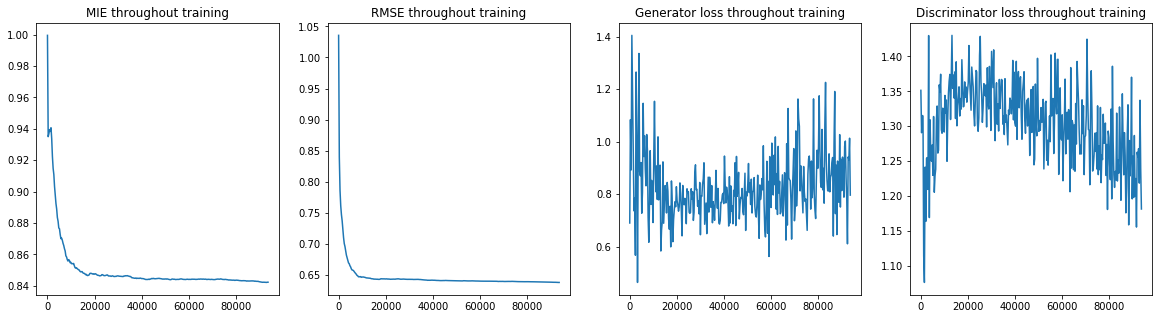

In [188]:
import matplotlib.pyplot as plt

fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
ax1.plot(df["Step"], df["MIE"])
ax2.plot(df["Step"], df["RMSE"])
ax3.plot(df["Step"], df["G_Loss"])
ax4.plot(df["Step"], df["D_Loss"])
ax1.set_title("MIE throughout training")
ax2.set_title("RMSE throughout training")
ax3.set_title("Generator loss throughout training")
ax4.set_title("Discriminator loss throughout training")

## Data Sampling

Let's see how the generators look. First, how does data from the final generator look like?

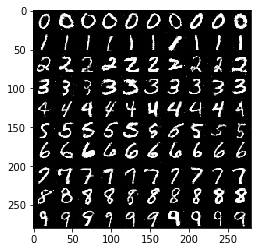

In [189]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

Let us now check the training steps at which we had the lowest values of MIE / RMSE respectively:

In [0]:
step_MIE = df["Step"][df["MIE"] == min(df["MIE"])]
step_RMSE = df["Step"][df["RMSE"] == min(df["RMSE"])]

In [198]:
step_MIE

309    92700
Name: Step, dtype: int64

In [199]:
step_RMSE

310    93000
Name: Step, dtype: int64

Let's check data from the generator with the lowest MIE:

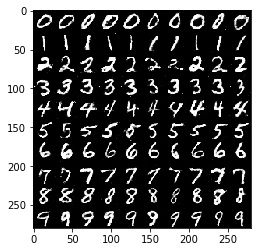

In [200]:
G_opt = torch.load("gen_iter " + str(92700) + ".pkl.gz")
G_opt.eval()
imshow(get_sample_image(G_opt, n_noise), cmap='gray')

And now data from the generator with the lowest RMSE:

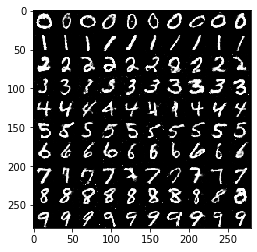

In [195]:
G_opt = torch.load("gen_iter " + str(93000) + ".pkl.gz")
G_opt.eval()
imshow(get_sample_image(G_opt, n_noise), cmap='gray')

## Moran's I embedding

To visualize how the Moran's I embedds spatial patterns, here is a random image from the last batch, together with its corresponding Moran's I values:

Text(0.5, 1.0, "Local Moran's I of grayscale values")

<Figure size 432x288 with 0 Axes>

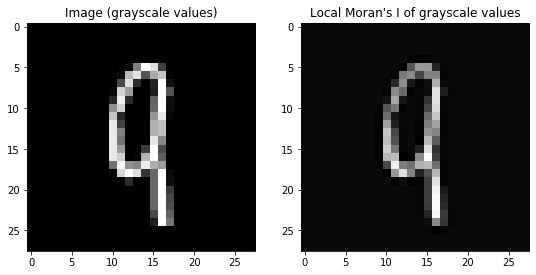

In [197]:
plt.gray()

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
ax2.imshow(pysal.explore.esda.moran.Moran_Local(x[42][0].cpu(),w,permutations=1).Is.reshape(28,28))
ax1.imshow(x[42][0].cpu())
ax1.set_title("Image (grayscale values)")
ax2.set_title("Local Moran's I of grayscale values")